Last Update: 2/4/2023

This notebook contains codes and results of VCL on permute MNIST dataset.

I also adopt tricks mentioned in Improving and Understanding
Variational Continual Learning:
- Longer training 
- Local reparameterization trick (also in the original VCL)
- random initialized mean

P.S. this notebook presents results of random coreset. Simply change random_coreset = True if coreset by kcenter alg is needed. 

P.P.S this notebook does not implement multi-head network.

In [ ]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence, Normal
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms

In [ ]:
class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_loc = nn.Parameter(torch.zeros(in_features, out_features))
        self.log_weight_scale = nn.Parameter(torch.zeros(in_features, out_features))
        
        self.bias_loc = nn.Parameter(torch.zeros(out_features))
        self.log_bias_scale = nn.Parameter(torch.zeros(out_features))
        
    def get_params(self):
        """
        return two tensors, obtaining by concatenating locs and scales together
        these parameters can be further used to calculate e.g, KL divergence (vectorizedly)
        """
        return (
                torch.cat([self.weight_loc.flatten(), self.bias_loc.flatten()]), 
                torch.cat([self.log_weight_scale.flatten(), self.log_bias_scale.flatten()])
               )
    
    def forward(self, x, x_is_sample, activition_fn, n_particles):
        """
        forward with local reparameterization tricks
        """
        ys = []
        if x_is_sample:
            assert n_particles == len(x)
            for _x in x:
                gamma = _x @ self.weight_loc + self.bias_loc
                delta2 = (_x ** 2) @ (torch.exp(self.log_weight_scale) ** 2) + torch.exp(self.log_bias_scale) ** 2
                y = gamma + torch.randn_like(gamma) * torch.sqrt(delta2 + 1e-6) 
                ys.append(activition_fn(y))
        else:
            for _ in range(n_particles):
                gamma = x @ self.weight_loc + self.bias_loc
                delta2 = (x ** 2) @ (torch.exp(self.log_weight_scale) ** 2) + torch.exp(self.log_bias_scale) ** 2
                y = gamma + torch.randn_like(gamma) * torch.sqrt(delta2 + 1e-6) 
                ys.append(activition_fn(y))
        return ys
    
    def forward_MLE(self, x, activition_fn):
        y = x @ self.weight_loc + self.bias_loc
        return activition_fn(y)


In [ ]:
# Implement Gonzalez Algorithm for k-Center Clustering for Coreset selection

class KCenter:
    def __init__(self, K):
        self.K = K
    def fit_transform(self, x):
        # fit and return centers
        idx1 = np.random.choice(x.shape[0], 1)
        center = x[idx1] # (1, d)
        idx = [idx1.item()]
        min_distances_to_centers = np.full([1, x.shape[0]], np.inf)
        for k in tqdm(range(1, self.K)):
            distances = ((x[None, :, :] - center[:, None, :]) ** 2).sum(-1) # 1, N
            min_distances_to_centers = np.vstack([min_distances_to_centers, distances]).min(0)
            new_center_idx = np.argmax(min_distances_to_centers).item()
            idx.append(new_center_idx)
            center = x[[new_center_idx]]
        assert len(idx) == self.K
        return idx

In [ ]:
class VCL_permute_MNIST(nn.Module):
    def __init__(self, previous_model, random_initialize):
        super().__init__()
        
        # "fully connected single-head networks with two hidden layers, where each layer contains 100 hidden units with ReLU activation"
        self.linear1 = BayesLinear(28*28, 100)
        self.linear2 = BayesLinear(100, 100)
        self.head = BayesLinear(100, 10)
        
        # intialize distributions as prior distributions
        # I believe there exist better ways to do this, but I am too lazy to think..(sorry)
        
        # define a layer dict
        self.layer_dict = OrderedDict()
        self.layer_dict["linear1"] = self.linear1
        self.layer_dict["linear2"] = self.linear2
        self.layer_dict["head"] = self.head
        
        # just a sanity check 
        assert id(self.layer_dict["linear1"]) == id(self.linear1)
        
        
        with torch.no_grad():
            if previous_model != None:
                for key in self.layer_dict:
                    self.layer_dict[key].weight_loc.data = previous_model.layer_dict[key].weight_loc.data.clone()
                    self.layer_dict[key].bias_loc.data = previous_model.layer_dict[key].bias_loc.data.clone()
                    self.layer_dict[key].log_weight_scale.data  = previous_model.layer_dict[key].log_weight_scale.data.clone()
                    self.layer_dict[key].log_bias_scale.data  = previous_model.layer_dict[key].log_bias_scale.data.clone()
            if random_initialize: 
                # the first model's initialization
                # 0 mean and very small variances (do not need to break the symmetricity since the training is based on random samples)
                for key in self.layer_dict:
                    self.layer_dict[key].weight_loc.data = torch.randn_like(self.layer_dict[key].weight_loc.data) * 0.1
                    self.layer_dict[key].bias_loc.data = torch.randn_like(self.layer_dict[key].bias_loc.data) * 0.1
                    # initialize to very small value for the first model
                    self.layer_dict[key].log_weight_scale.data  = torch.zeros_like(self.layer_dict[key].log_weight_scale.data) - 3
                    self.layer_dict[key].log_bias_scale.data  = torch.zeros_like(self.layer_dict[key].log_bias_scale.data) - 3
        
        # also save parameters of the previous model, for the calculation of ELBO
        if  previous_model != None:
            previous_locs, previous_logscales = previous_model.get_params()
            previous_locs, previous_logscales = previous_locs.detach().clone(), previous_logscales.detach().clone()
            self.previous_model_locs = previous_locs
            self.previous_model_log_scales = previous_logscales
        else:
            self.previous_model_locs = None
            self.previous_model_log_scales = None
        
    def predict(self, x, n_particles):
        hiddens =  self.linear1.forward(x, x_is_sample=False, activition_fn=nn.ReLU(), n_particles=n_particles)
        hiddens =  self.linear2.forward(hiddens, x_is_sample=True, activition_fn=nn.ReLU(), n_particles=n_particles)
        logits = self.head.forward(hiddens, x_is_sample=True, activition_fn=nn.Identity(), n_particles=n_particles)
        return logits # a list of logits calculated from samples
    
    def predict_MLE(self, x):
        hiddens =  self.linear1.forward_MLE(x, nn.ReLU())
        hiddens =  self.linear2.forward_MLE(hiddens, nn.ReLU())
        logits = self.head.forward_MLE(hiddens, nn.Identity())
        return logits
    
    def get_params(self):  
        locs = []
        logscales = []
        for key in self.layer_dict:
            loc, scale = self.layer_dict[key].get_params()
            locs.append(loc)
            logscales.append(scale)
        locs = torch.cat(locs)
        logscales = torch.cat(logscales)
        return locs, logscales
    
    def calculate_ELBO(self, x, y, n_particles, dataset_size):
        
        locs, logscales = self.get_params()
        # calculate KL between "prior" and posterior
        KL = kl_divergence(Normal(loc=locs, scale=torch.exp(logscales)),
                           Normal(loc=self.previous_model_locs, scale=torch.exp(self.previous_model_log_scales))
                          )
        nELBO = 0 
        for _ in range(n_particles):
            logit = self.predict(x, 1)[0]
            neg_log_p = nn.CrossEntropyLoss(reduction='sum')(logit, y)
            nELBO = neg_log_p + nELBO
        nELBO = nELBO / n_particles / x.shape[0] + KL.sum() / dataset_size 
        # since the ELBO can be viewed as an MC estimator over dataset. Keep the magnitude same is of vital importance!!!
                  
        return nELBO  
    def MLE_loss(self, x, y):
        logit = self.predict_MLE(x)
        loss = nn.CrossEntropyLoss(reduction='mean')(logit, y)
        return loss


In [ ]:
ds_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
ds_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
def get_pMNIST(task_idx, device):
    np.random.seed(task_idx)
    permute_idx = np.random.choice(28*28, 28*28, False)
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train]))[:, permute_idx]
    train_y = torch.tensor([d[1] for d in ds_train])
    
    test_x = nn.Flatten()(torch.cat([d[0] for d in ds_test]))[:, permute_idx]
    test_y = torch.tensor([d[1] for d in ds_test])
    
    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

In [ ]:
device = "cuda"

In [ ]:
previous_model = VCL_permute_MNIST(previous_model=None, random_initialize=False).to(device) # initialize a prior model

In [ ]:
Test_x = []
Test_y = []

coreset_x = None
coreset_y = None
coreset_size = 200

batch_size = 256

In [ ]:
random_coreset = True

In [ ]:
Accuracies = []

In [ ]:
n_epochs = 200

100%|██████████| 200/200 [04:04<00:00,  1.22s/it]


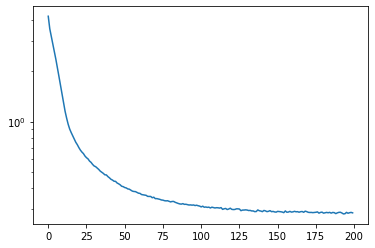

Accuracy by the propagration model is 0.9768


100%|██████████| 200/200 [00:01<00:00, 192.30it/s]


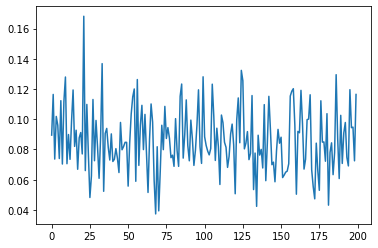

Task 0, Accuracy: 0.9766


100%|██████████| 200/200 [04:06<00:00,  1.23s/it]


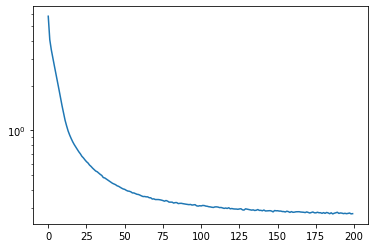

Accuracy by the propagration model is 0.8912


100%|██████████| 200/200 [00:02<00:00, 93.82it/s]


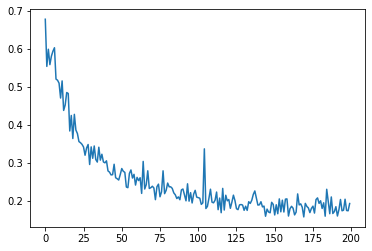

Task 1, Accuracy: 0.9739


100%|██████████| 200/200 [04:05<00:00,  1.23s/it]


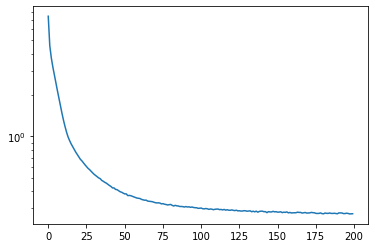

Accuracy by the propagration model is 0.9403


100%|██████████| 200/200 [00:03<00:00, 62.17it/s]


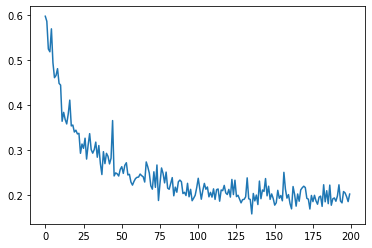

Task 2, Accuracy: 0.9705


100%|██████████| 200/200 [04:05<00:00,  1.23s/it]


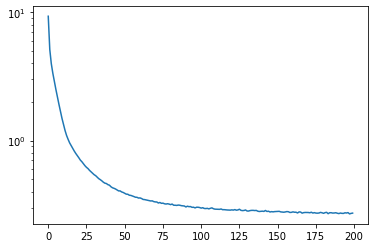

Accuracy by the propagration model is 0.9118


100%|██████████| 200/200 [00:04<00:00, 46.90it/s]


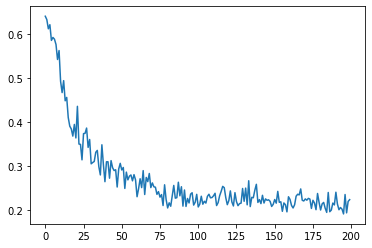

Task 3, Accuracy: 0.9696


100%|██████████| 200/200 [04:05<00:00,  1.23s/it]


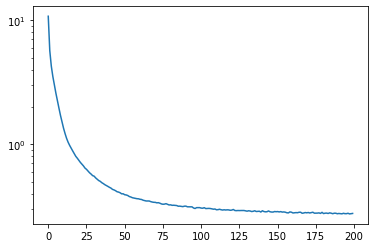

Accuracy by the propagration model is 0.9129


100%|██████████| 200/200 [00:04<00:00, 44.26it/s]


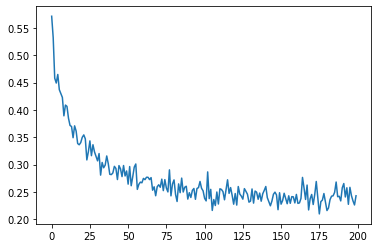

Task 4, Accuracy: 0.9682


100%|██████████| 200/200 [04:07<00:00,  1.24s/it]


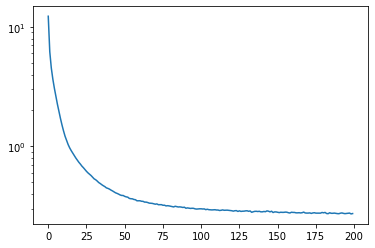

Accuracy by the propagration model is 0.9535


100%|██████████| 200/200 [00:05<00:00, 36.94it/s]


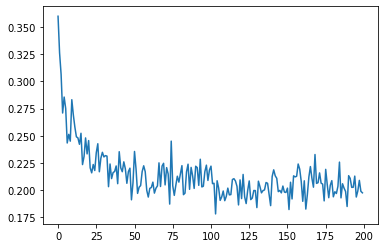

Task 5, Accuracy: 0.9657


100%|██████████| 200/200 [04:04<00:00,  1.22s/it]


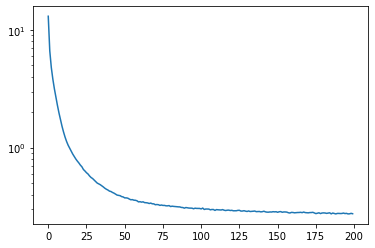

Accuracy by the propagration model is 0.9468


100%|██████████| 200/200 [00:06<00:00, 30.47it/s]


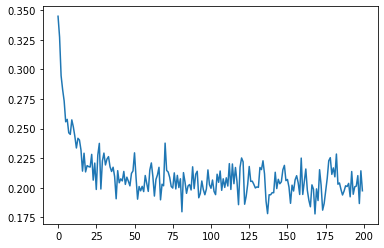

Task 6, Accuracy: 0.9627


100%|██████████| 200/200 [04:04<00:00,  1.22s/it]


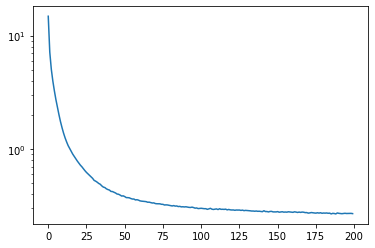

Accuracy by the propagration model is 0.9322


100%|██████████| 200/200 [00:08<00:00, 23.38it/s]


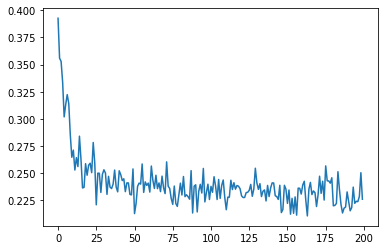

Task 7, Accuracy: 0.9591


100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


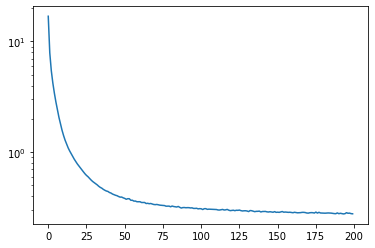

Accuracy by the propagration model is 0.9169


100%|██████████| 200/200 [00:08<00:00, 23.35it/s]


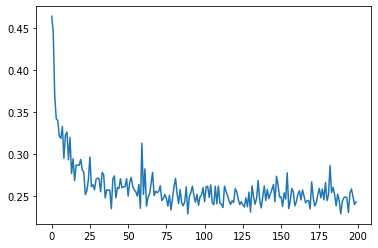

Task 8, Accuracy: 0.9544


100%|██████████| 200/200 [04:01<00:00,  1.21s/it]


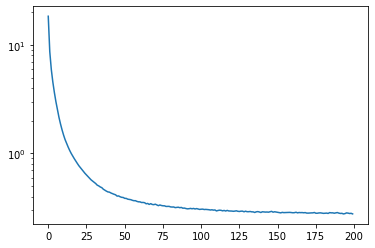

Accuracy by the propagration model is 0.9112


100%|██████████| 200/200 [00:08<00:00, 23.02it/s]


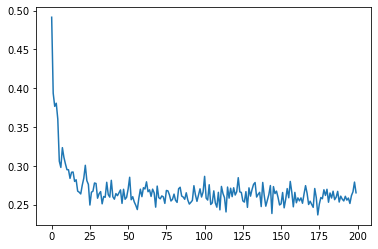

Task 9, Accuracy: 0.9510


In [ ]:
for task in range(10):
    train_x, train_y, test_x, test_y = get_pMNIST(task, device)
    Test_x.append(test_x)
    Test_y.append(test_y)
    
    # define current model
    current_model = VCL_permute_MNIST(previous_model=previous_model, random_initialize=True).to(device)
    current_opt = torch.optim.Adam(current_model.parameters(), lr=0.001)

    # get coreset
    if random_coreset:
        coreset_idx = np.random.choice(train_x.shape[0], coreset_size, False)
    else:
        coreset_idx = np.array(KCenter(coreset_size).fit_transform(train_x.cpu().detach().numpy())) 
    train_idx = np.delete(np.arange(train_x.shape[0]), coreset_idx)
    new_coreset_x = train_x[coreset_idx]
    new_coreset_y = train_y[coreset_idx]
    train_x = train_x[train_idx]
    train_y = train_y[train_idx]

    if coreset_x == None:
        coreset_x = new_coreset_x
        coreset_y = new_coreset_y
    else:
        coreset_x = torch.cat([new_coreset_x, coreset_x])
        coreset_y = torch.cat([new_coreset_y, coreset_y])
        # "For all the algorithms with coresets, we choose 200 examples from each task to include into the coresets"

    ELBO = []
    for epoch in tqdm(range(n_epochs)):
        ELBO_batch = []
        for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            
            current_opt.zero_grad()
            elbo = current_model.calculate_ELBO(x=train_x[batch_idx0: batch_idx1], 
                                                y=train_y[batch_idx0: batch_idx1], 
                                                n_particles=1,
                                                dataset_size=train_x.shape[0])
            elbo.backward()
            nn.utils.clip_grad_value_(current_model.parameters(), 5)
            current_opt.step()
            ELBO_batch.append(elbo.item())
        ELBO.append(np.mean(ELBO_batch))
    plt.plot(ELBO)
    plt.yscale("log")
    plt.show()

    test_x_tensor = torch.cat(Test_x)
    test_y_tensor = torch.cat(Test_y)
    pred_y = []
    with torch.no_grad():
        for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_logit_samples = nn.Softmax(-1)(torch.stack(current_model.predict(test_x_tensor[batch_idx0: batch_idx1], 100), 0)).mean(0)
            pred_y.append(pred_logit_samples.argmax(-1))
        pred_y = torch.cat(pred_y)
        acc = (pred_y == test_y_tensor).cpu().numpy().mean()
    print("Accuracy by the propagration model is %.4f"%acc)
        
    # calculate prediction model
    pred_model = VCL_permute_MNIST(previous_model=current_model, random_initialize=False).to(device)
    pred_opt = torch.optim.Adam(pred_model.parameters(), lr=0.001)

    ELBO = []
    for epoch in tqdm(range(n_epochs)):
        ELBO_batch = []
        for batch in range(int(np.ceil(coreset_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_opt.zero_grad()
            elbo = pred_model.calculate_ELBO(x=coreset_x[batch_idx0: batch_idx1], 
                                             y=coreset_y[batch_idx0: batch_idx1], 
                                             n_particles=1,
                                             dataset_size=coreset_x.shape[0])
            elbo.backward()
            nn.utils.clip_grad_value_(pred_model.parameters(), 5)
            pred_opt.step()
            ELBO_batch.append(elbo.item())
        ELBO.append(np.mean(ELBO_batch))
    plt.plot(ELBO)
    plt.show()
            
    test_x_tensor = torch.cat(Test_x)
    test_y_tensor = torch.cat(Test_y)
    pred_y = []
    with torch.no_grad():
        for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_logit_samples = nn.Softmax(-1)(torch.stack(pred_model.predict(test_x_tensor[batch_idx0: batch_idx1], 100), 0)).mean(0)
            pred_y.append(pred_logit_samples.argmax(-1))
        pred_y = torch.cat(pred_y)
        acc = (pred_y == test_y_tensor).cpu().numpy().mean()
    Accuracies.append(acc)
    print("Task {:d}, Accuracy: {:.4f}".format(task, acc))
    previous_model = current_model

In [ ]:
print(Accuracies)

[0.9766, 0.9739, 0.9705333333333334, 0.969625, 0.96824, 0.9656833333333333, 0.9627142857142857, 0.9591125, 0.9544222222222222, 0.951]


Text(0, 0.5, 'Accuracy')

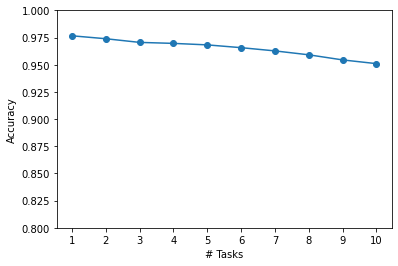

In [ ]:
plt.plot(np.arange(1, 11), Accuracies)
plt.scatter(np.arange(1, 11), Accuracies)
plt.xticks(np.arange(1, 11))
plt.ylim(0.8, 1)
plt.xlabel("# Tasks")
plt.ylabel("Accuracy")